# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, min, max, sum, count, udf

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import  StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import IntegerType, FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
df.count()

286500

In [7]:
# drop nas in userId or sessionId
user_log_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [8]:
user_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
# drop empty userIds
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [10]:
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### preliminary analysis

In [11]:
# describe some of the important columns

In [12]:
user_log_valid.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [13]:
user_log_valid.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [14]:
total_users = user_log_valid.select("userId").dropDuplicates().count()

In [15]:
total_users

225

In [16]:
user_log_valid.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [17]:
# look at possible pages
user_log_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Define Churn

In [18]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("churned", flag_churn_event("page"))

In [19]:
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churned=0)

### Explore data

#### Users churning %

In [20]:
# check which users have churned
user_churned = user_log_valid.groupBy('userId').agg(max('churned').alias('user_churned'))
user_churned.show()

+------+------------+
|userId|user_churned|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|    51|           1|
|   124|           0|
|     7|           0|
|    54|           1|
|    15|           0|
|   155|           0|
|   132|           0|
|   154|           0|
|100014|           1|
|   101|           1|
|    11|           0|
|   138|           0|
|300017|           0|
|    29|           1|
|    69|           0|
|100021|           1|
|    42|           0|
+------+------------+
only showing top 20 rows



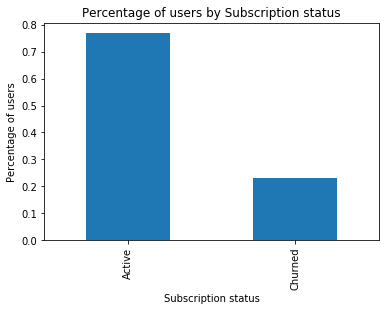

In [21]:
# Percentage of users by Subscription status
churn_count_pd = user_churned.groupby('user_churned').count().toPandas().set_index('user_churned').sort_index()
plt.figure()
(churn_count_pd/churn_count_pd.sum()).plot.bar(legend=None)
churn_labels = ['Active', 'Churned']
x_pos = np.arange(len(churn_labels))
plt.xticks(x_pos,churn_labels)
plt.title('Percentage of users by Subscription status')
plt.ylabel('Percentage of users')
plt.xlabel('Subscription status')
plt.show()

Around 1/4 of the users have churned

#### merging user churned info to original df

In [22]:
# join subscription status to the original data frame to analyze potential features
user_log_valid = user_log_valid.join(user_churned, on=['userId'], how='left')

In [23]:
user_log_valid.head()

Row(userId='100010', artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', churned=0, user_churned=0)

In [24]:
user_log_valid.count()

278154

#### churned/active by events

In [25]:
user_log_valid.groupby(['page']).count().orderBy('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [26]:
churn_page_count_pd = user_log_valid.groupby(['page','user_churned']).count().toPandas()

In [27]:
relevant_pages_list = ['Add Friend', 'Add to Playlist', 'Roll Advert', 'Thumbs Down', 'Thumbs Up']
churn_page_count_pd = user_log_valid.groupby(['page','user_churned']).count().toPandas()
# NextSong is by by far the largest value, so we delete it before calculating sum of the rest
churn_page_count_pd = churn_page_count_pd[churn_page_count_pd.page != 'NextSong']
# get the sum of all pages but NextSong
total_pages = churn_page_count_pd.groupby(['user_churned']).sum()
# filter for pages I want to use as potential features
churn_page_count_pd = churn_page_count_pd[churn_page_count_pd.page.isin(relevant_pages_list)]
churn_page_count_pd = (churn_page_count_pd.set_index(['page', 'user_churned']) / total_pages).reset_index()
churn_page_count_pd['user_churned'] = churn_page_count_pd['user_churned'].replace({0:'No', 1: 'Yes'})

Text(0.5,0,'Percentage of Events')

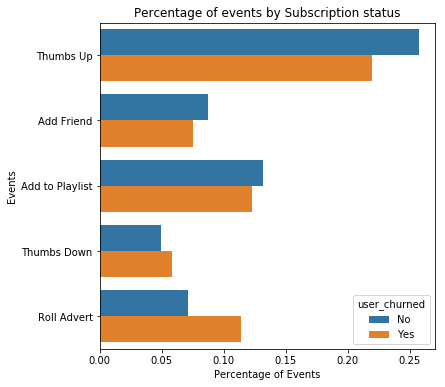

In [28]:
plt.figure(figsize=(6,6))
sns.barplot(y = 'page', x = 'count', data = churn_page_count_pd, hue = 'user_churned')
plt.title('Percentage of events by Subscription status')
plt.ylabel('Events')
plt.xlabel('Percentage of Events')

It seems that users that did not churn seem to engange more positive against sparkify

- they give more thumbs up
- they add more friends
- they add more songs to playlists

User that churn in contrast

- give more thumbs down
- they are more likely to roll advert

#### songs listened per user

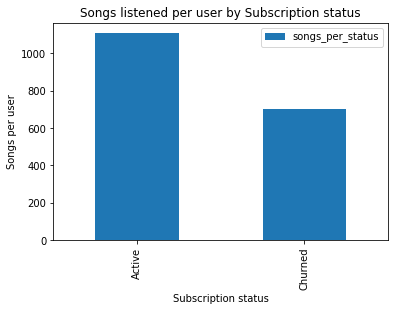

In [29]:
songs_per_user = user_log_valid.filter(user_log_valid['song'].isNotNull()).select('userId', 'song').groupby('userId').count()
songs_per_user = songs_per_user.join(user_churned, on=['userId'], how='left')
songs_per_status = songs_per_user.select('count', 'user_churned').groupby('user_churned').agg(avg('count').alias('songs_per_status'))
songs_per_status = songs_per_status.toPandas().set_index('user_churned').sort_index()
songs_per_status.plot.bar()
churn_labels = ['Active', 'Churned']
x_pos = np.arange(len(churn_labels))
plt.xticks(x_pos,churn_labels)
plt.title('Songs listened per user by Subscription status')
plt.ylabel('Songs per user')
plt.xlabel('Subscription status')
plt.show()

Active users have more songs in average

#### time spend per user

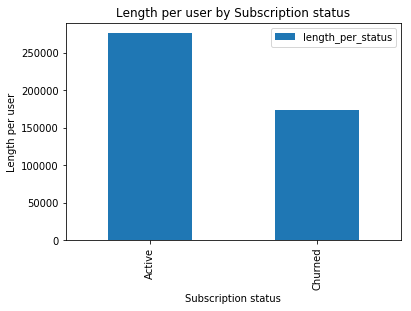

In [30]:
songs_per_user = user_log_valid.filter(user_log_valid['length'].isNotNull()).select('userId', 'length').groupby('userId').agg(sum('length').alias('length_per_user'))
songs_per_user = songs_per_user.join(user_churned, on=['userId'], how='left')
songs_per_status = songs_per_user.select('length_per_user', 'user_churned').groupby('user_churned').agg(avg('length_per_user').alias('length_per_status'))
songs_per_status = songs_per_status.toPandas().set_index('user_churned').sort_index()
songs_per_status.plot.bar()
churn_labels = ['Active', 'Churned']
x_pos = np.arange(len(churn_labels))
plt.xticks(x_pos,churn_labels)
plt.title('Length per user by Subscription status')
plt.ylabel('Length per user')
plt.xlabel('Subscription status')
plt.show()

Active users have spend more time listening to songs on average

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Engineer Features

In [31]:
# Number of thumbs up
feature_1 = user_log_valid.select('userID','page').where(user_log_valid.page == 'Thumbs Up').groupBy('userID').agg(count('page').alias('num_thumb_up'))

# Number of thumbs down
feature_2 = user_log_valid.select('userID','page').where(user_log_valid.page == 'Thumbs Down').groupBy('userID').agg(count('page').alias('num_thumb_down'))

# Number of adds to playlist
feature_3 = user_log_valid.select('userID','page').where(user_log_valid.page == 'Add to Playlist').groupBy('userID').agg(count('page').alias('num_add_paylist'))

# Number of adds to friends
feature_4 = user_log_valid.select('userID','page').where(user_log_valid.page == 'Add Friend').groupBy('userID').agg(count('page').alias('num_add_friends'))

# Number of Roll Adverts
feature_5 = user_log_valid.select('userID','page').where(user_log_valid.page == 'Roll Advert').groupBy('userID').agg(count('page').alias('num_roll_adverts'))

# Number of Songs played
feature_6 = user_log_valid.filter(user_log_valid['song'].isNotNull()).select('userId', 'song').groupBy('userID').agg(count('song').alias('songs_played'))

# Time Spend
feature_7 = user_log_valid.filter(user_log_valid['length'].isNotNull()).select('userId', 'length').groupBy('userID').agg(sum('length').alias('time_listened'))

# Artists listened
feature_8 = user_log_valid.filter(user_log_valid.page == 'NextSong').select('userId', 'artist').dropDuplicates().groupBy('userID').agg(count('artist').alias('artists_listened'))

#### Engineer target label

In [32]:
target = user_log_valid.select('userId', col('user_churned').alias('label')).dropDuplicates()

#### Join everything together

In [33]:
df_final  = feature_1.join(feature_2, on=['userID'], how='outer') \
    .join(feature_3, on=['userID'], how='outer') \
    .join(feature_4, on=['userID'], how='outer') \
    .join(feature_5, on=['userID'], how='outer') \
    .join(feature_6, on=['userID'], how='outer') \
    .join(feature_7, on=['userID'], how='outer') \
    .join(feature_8, on=['userID'], how='outer') \
    .join(target, on=['userID'], how='outer') \
    .drop('userID')

In [34]:
df_final = df_final.fillna(0)

In [35]:
df_final.head()

Row(num_thumb_up=17, num_thumb_down=5, num_add_paylist=7, num_add_friends=4, num_roll_adverts=52, songs_played=275, time_listened=66940.89735000003, artists_listened=252, label=0)

#### vector assembler, normalizer and scaler

In [36]:
feature_cols = ['num_thumb_up', 'num_thumb_down', 'num_add_paylist', 'num_add_friends', 'num_roll_adverts', 'songs_played',
               'time_listened', 'artists_listened']

In [37]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="NumFeatures")
df_final = assembler.transform(df_final)

In [38]:
df_final.head()

Row(num_thumb_up=17, num_thumb_down=5, num_add_paylist=7, num_add_friends=4, num_roll_adverts=52, songs_played=275, time_listened=66940.89735000003, artists_listened=252, label=0, NumFeatures=DenseVector([17.0, 5.0, 7.0, 4.0, 52.0, 275.0, 66940.8974, 252.0]))

In [39]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(df_final)
df_final = scalerModel.transform(df_final)

In [40]:
df_final.head()

Row(num_thumb_up=17, num_thumb_down=5, num_add_paylist=7, num_add_friends=4, num_roll_adverts=52, songs_played=275, time_listened=66940.89735000003, artists_listened=252, label=0, NumFeatures=DenseVector([17.0, 5.0, 7.0, 4.0, 52.0, 275.0, 66940.8974, 252.0]), features=DenseVector([0.2596, 0.3823, 0.214, 0.1943, 2.413, 0.2489, 0.2431, 0.4173]))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [41]:
train, test = df_final.select('label', 'features').randomSplit([0.8, 0.2], seed=1)

In [42]:
'''
since seen above the ratio between active/churned customers is ~75%/25% which I would consider imbalanced,
I choose f1 score as optimization metric
'''

eval_f1 = MulticlassClassificationEvaluator(metricName='f1')

#### logistic regression

In [43]:
lr = LogisticRegression(maxIter=10)

In [44]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()
cv = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval_f1,
                          numFolds=3)

In [45]:
cvModel_lr = cv.fit(train)

In [46]:
cvModel_lr.avgMetrics

[0.6842233300665149,
 0.6842233300665149,
 0.6678312881606667,
 0.6678312881606667]

#### gradient boost tree

In [47]:
gbt = GBTClassifier(maxIter = 10, seed=1)

In [48]:
paramGrid_gb = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
cv_gb = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gb,
                          evaluator=eval_f1,
                          numFolds=3)

In [49]:
cvModel_gb = cv_gb.fit(train)

In [50]:
cvModel_gb.avgMetrics

[0.6572284141373747, 0.6549952424646165]

#### evaluate

In [51]:
predictions_lr = cvModel_lr.transform(test)
predictions_gb = cvModel_gb.transform(test)

In [52]:
# from: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels_lr = predictions_lr.select(['prediction','label'])

#select only prediction and label columns
preds_and_labels_lr = preds_and_labels_lr.withColumn('label', col('label').cast(FloatType())).orderBy('prediction')

metrics_lr = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple))

print(metrics_lr.confusionMatrix().toArray())

[[ 32.   0.]
 [  9.   0.]]


In [53]:
metrics_lr.accuracy

0.7804878048780488

In [54]:
# from: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels_gb = predictions_gb.select(['prediction','label'])

#select only prediction and label columns
preds_and_labels_gb = preds_and_labels_gb.withColumn('label', col('label').cast(FloatType())).orderBy('prediction')

metrics_gb = MulticlassMetrics(preds_and_labels_gb.rdd.map(tuple))

print(metrics_gb.confusionMatrix().toArray())

[[ 29.   3.]
 [  6.   3.]]


In [55]:
metrics_gb.accuracy

0.7804878048780488

Results:
- The accuracy of both models is identical
- logistic regression has the better f1 score
- looking at the evaluation matrics, we can see that logistic regression is only predicting active customers which is quite bad
- it is especially bad because false positive hurt as more than false negatives
- therefore I will choose the GBT Model and further analyze it
- more information and additional explanation regarding this can be found in my medium post which is linked in the github readme


#### Looking at feature importance of GBT Model

In [56]:
feature_imp = cvModel_gb.bestModel.featureImportances.values
feature_imp

array([ 0.18265661,  0.16315991,  0.0855828 ,  0.26827336,  0.16469028,
        0.05103215,  0.04295941,  0.04164548])

Text(0.5,1,'GBT Feature Importances')

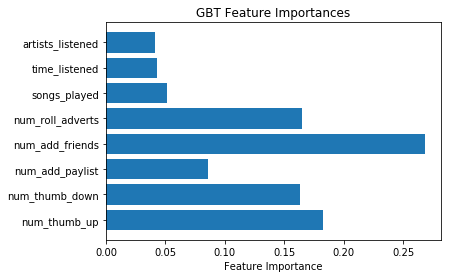

In [57]:
y_pos = np.arange(len(feature_imp))

plt.barh(y_pos, feature_imp, align='center')
plt.yticks(y_pos, feature_cols)
plt.xlabel('Feature Importance')
plt.title('GBT Feature Importances')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.